# Northwind Traders Analysis
ELİF ATASAL AUGUST 2024

In [20]:
!pip install psycopg2 pandas sqlalchemy matplotlib seaborn

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.io.sql as sqlio
import psycopg2 as ps

In [24]:
from sqlalchemy import create_engine
import pandas as pd

db_user = 'postgres'
db_password = 'elfcc'
db_host = 'localhost'
db_port = '5432'
db_name = 'Nortwind'


In [25]:
connection_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

In [26]:
engine = create_engine(connection_string)

# SALES ANALYSIS

# Total Sales by Monthly and Quarterly

In [27]:
query = """
SELECT
    EXTRACT(YEAR FROM o.order_date) AS Year,
    CASE
        WHEN EXTRACT(MONTH FROM o.order_date) IN (1, 2, 3) THEN 'Q1'  -- 1. Dönem: Ocak, Şubat, Mart
        WHEN EXTRACT(MONTH FROM o.order_date) IN (4, 5, 6) THEN 'Q2'  -- 2. Dönem: Nisan, Mayıs, Haziran
        WHEN EXTRACT(MONTH FROM o.order_date) IN (7, 8, 9) THEN 'Q3'  -- 3. Dönem: Temmuz, Ağustos, Eylül
        ELSE 'Q4'  -- 4. Dönem: Ekim, Kasım, Aralık
    END AS Quarter,
    EXTRACT(MONTH FROM o.order_date) AS Month,
    SUM(od.unit_price * od.quantity) AS Total_Sales
FROM
    orders AS o
JOIN
    order_details od ON o.order_id = od.order_id
GROUP BY
    EXTRACT(YEAR FROM o.order_date),
    CASE
        WHEN EXTRACT(MONTH FROM o.order_date) IN (1, 2, 3) THEN 'Q1'
        WHEN EXTRACT(MONTH FROM o.order_date) IN (4, 5, 6) THEN 'Q2'
        WHEN EXTRACT(MONTH FROM o.order_date) IN (7, 8, 9) THEN 'Q3'
        ELSE 'Q4'
    END, 
    Month
ORDER BY
    Year, Quarter, Month;
"""

In [28]:
df = pd.read_sql_query(query, engine)

In [29]:
print(df.columns)
print(df.dtypes)

Index(['year', 'quarter', 'month', 'total_sales'], dtype='object')
year           float64
quarter         object
month          float64
total_sales    float64
dtype: object


In [30]:
df['year'] = df['year'].astype(int)

df['quarter'] = df['quarter'].astype('category')

df['month'] = df['month'].astype(int)

df['total_sales'] = pd.to_numeric(df['total_sales'], errors='coerce')

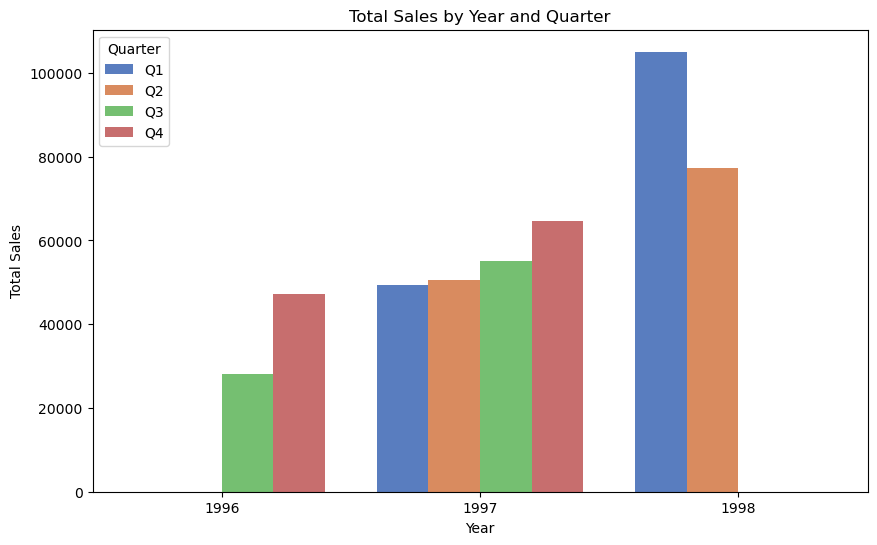

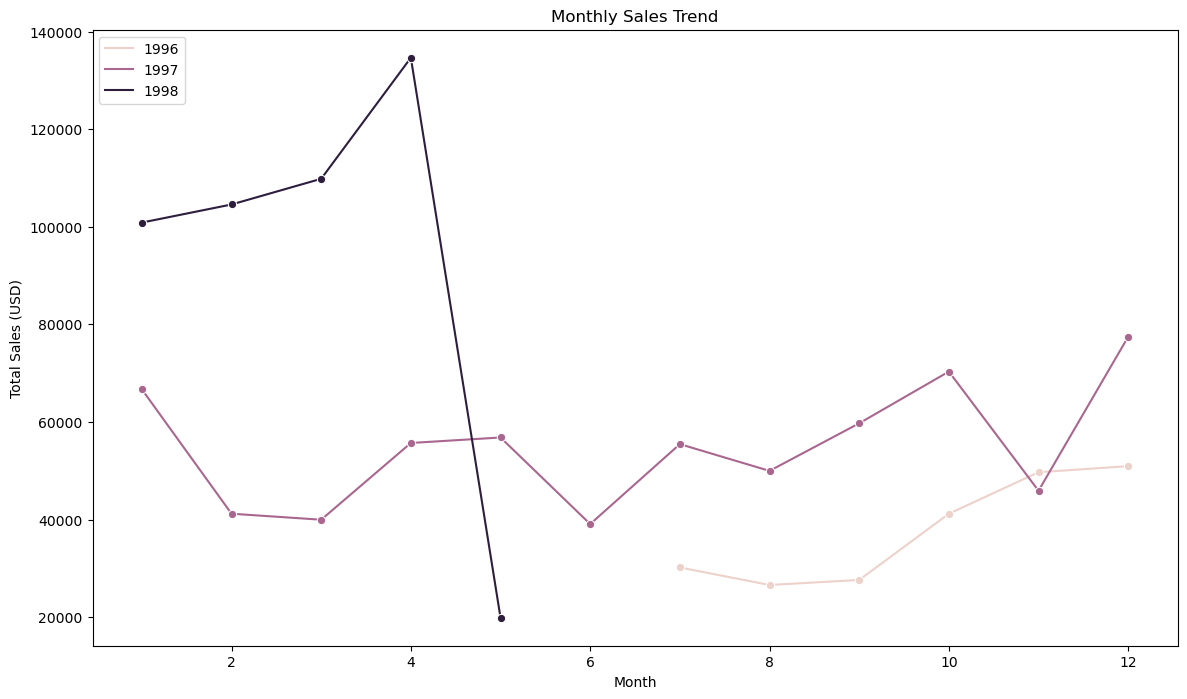

In [31]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df, x="year", y="total_sales", hue="quarter", palette="muted", errorbar=None)

plt.title("Total Sales by Year and Quarter")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.legend(title="Quarter", loc='upper left')

plt.show()

plt.figure(figsize=(14, 8))
ax2 = sns.lineplot(data=df, x="month", y="total_sales", hue="year", marker='o')
ax2.set_title("Monthly Sales Trend")
ax2.set_xlabel("Month")
ax2.set_ylabel("Total Sales (USD)")
ax2.legend(loc='upper left')

plt.show()


# Total Sales by Country

In [32]:
query2 = """SELECT
    c.country AS Country,
    COUNT(DISTINCT o.order_id) AS Total_Orders,
    SUM(od.unit_price * od.quantity) AS Total_Sales
FROM
    orders o
JOIN
    customers c ON o.customer_id = c.customer_id
JOIN
    order_details od ON o.order_id = od.order_id
GROUP BY
    c.country
ORDER BY
    Total_Sales DESC;
"""

In [33]:
df = pd.read_sql_query(query2, engine)

In [34]:
print(df.columns)
print(df.dtypes)

Index(['country', 'total_orders', 'total_sales'], dtype='object')
country          object
total_orders      int64
total_sales     float64
dtype: object


In [35]:
df['total_sales'] = pd.to_numeric(df['total_sales'], errors='coerce')

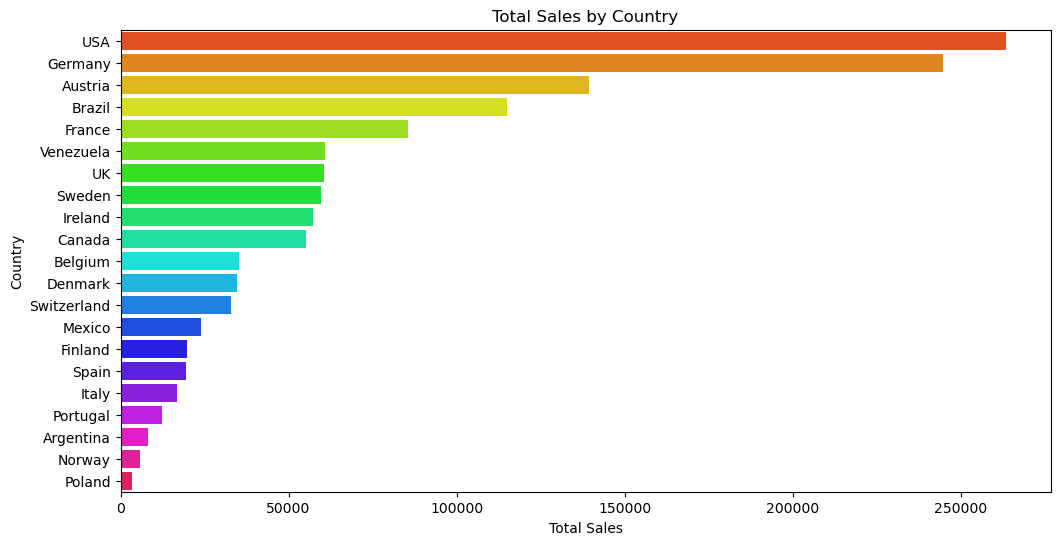

In [36]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette("hsv", len(df))

sns.barplot(data=df, x="total_sales", y="country", palette=colors)

plt.title("Total Sales by Country")
plt.xlabel("Total Sales")
plt.ylabel("Country")

plt.yticks(rotation=0)

plt.show()

# Total Sales by Employees

In [37]:
query3 = """SELECT
    e.country AS Office_Country,
    e.employee_id AS EmployeeID,
    e.first_name || ' ' || e.last_name AS Employee_Name,
    e.title AS Employee_Title,
    e.city AS Office_City,
    SUM(od.unit_price * od.quantity) AS Total_Sales
FROM
    orders o
JOIN
    employees e ON o.employee_id = e.employee_id
JOIN
    order_details od ON o.order_id = od.order_id
GROUP BY
    e.country, e.employee_id, e.first_name, e.last_name, e.title, e.city
ORDER BY
    Total_Sales DESC;
"""

In [38]:
df = pd.read_sql_query(query3, engine)

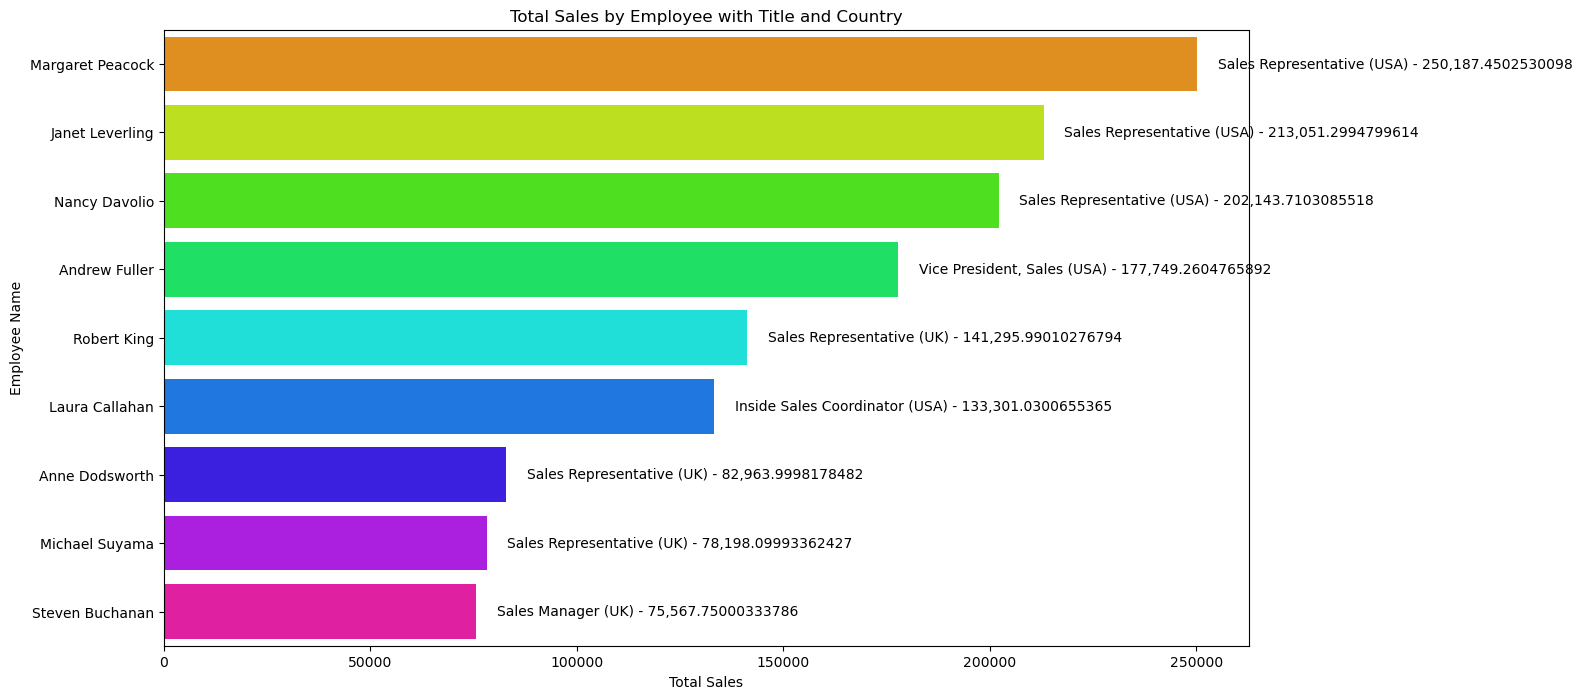

In [39]:
plt.figure(figsize=(14, 8))

colors = sns.color_palette("hsv", len(df))

sns.barplot(data=df, x="total_sales", y="employee_name", palette=colors)

for index, row in df.iterrows():
    info_text = f'{row["employee_title"]} ({row["office_country"]}) - {row["total_sales"]:,}'
    plt.text(x=row['total_sales'] + 5000, y=index, s=info_text, va='center')

plt.title("Total Sales by Employee with Title and Country")
plt.xlabel("Total Sales")
plt.ylabel("Employee Name")

plt.yticks(rotation=0)

plt.show()

# CUSTOMER ANALYSIS

# Total Sales and Sales Percentage of Customers by Country 

In [40]:
query4 = """WITH TotalSales AS (
    SELECT
        SUM(od.unit_price * od.quantity) AS Grand_Total_Sales
    FROM
        order_details od
)

SELECT
    c.country AS Country,
    COUNT(DISTINCT c.customer_id) AS Customer_Count,
    SUM(od.unit_price * od.quantity) AS Total_Sales,
    (SUM(od.unit_price * od.quantity) / ts.Grand_Total_Sales) * 100 AS Sales_Percentage
FROM
    customers c
JOIN
    orders o ON c.customer_id = o.customer_id
JOIN
    order_details od ON o.order_id = od.order_id
CROSS JOIN
    TotalSales ts
GROUP BY
    c.country, ts.Grand_Total_Sales
ORDER BY
    Total_Sales DESC;
    """

In [41]:
df = pd.read_sql_query(query4, engine)

In [42]:
print(df.columns)
print(df.dtypes)

Index(['country', 'customer_count', 'total_sales', 'sales_percentage'], dtype='object')
country              object
customer_count        int64
total_sales         float64
sales_percentage    float64
dtype: object


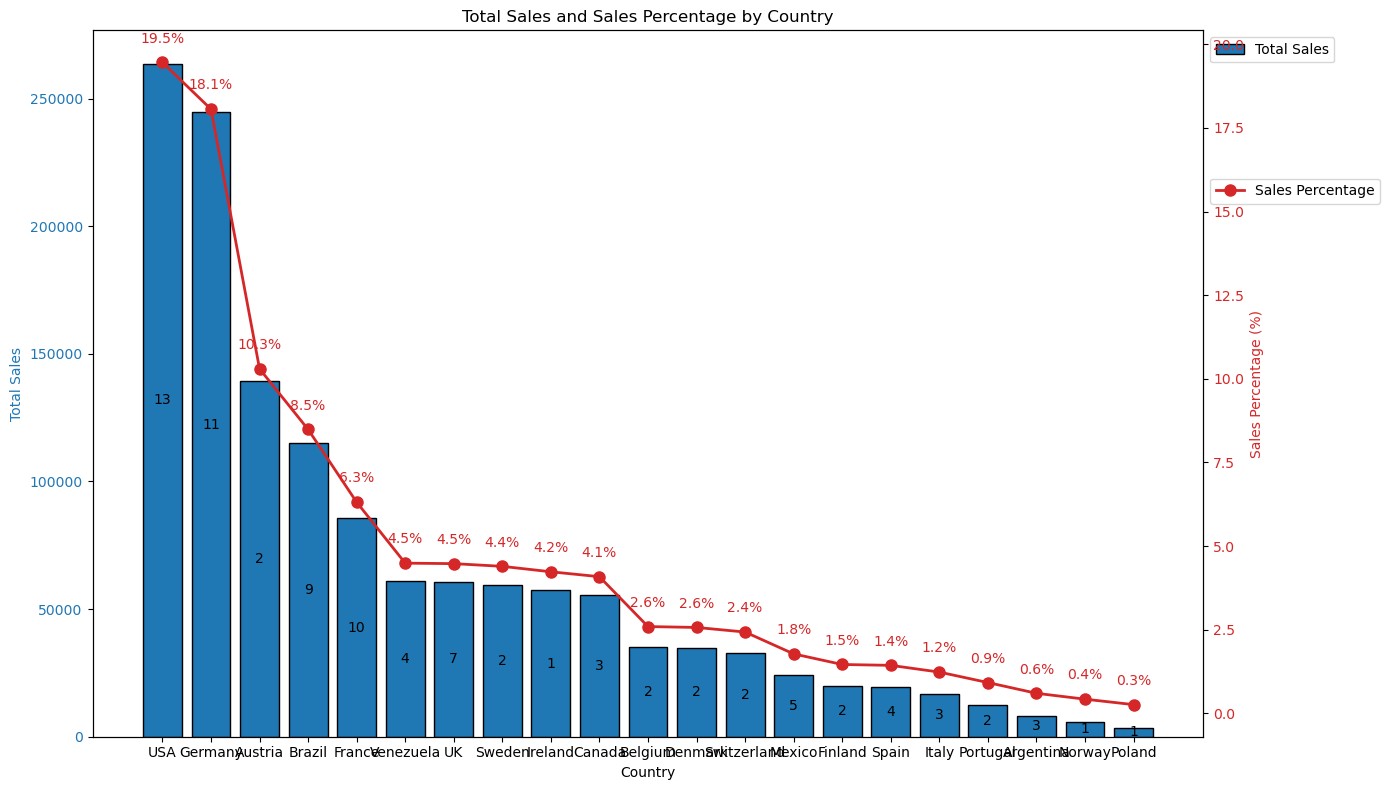

In [43]:
fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:blue'
ax1.set_xlabel('Country')
ax1.set_ylabel('Total Sales', color=color)
bars = ax1.bar(df['country'], df['total_sales'], color=color, edgecolor='black', label='Total Sales')
ax1.tick_params(axis='y', labelcolor=color)

for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval/2, df['customer_count'][bars.index(bar)], 
             va='center', ha='center', color='black', fontsize=10)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Sales Percentage (%)', color=color)
lineplot = ax2.plot(df['country'], df['sales_percentage'], color=color, marker='o', linestyle='-', linewidth=2, markersize=8, label='Sales Percentage')

for x, y in zip(df['country'], df['sales_percentage']):
    ax2.text(x, y + 0.5, f'{y:.1f}%', color=color, ha='center', va='bottom', fontsize=10)

ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Sales and Sales Percentage by Country')
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.8))


plt.xticks(rotation=0, ha='center')


plt.tight_layout()
plt.show()

# Top 5 Customers by Year - Total Sales and Orders

In [44]:
query5 = """WITH Top5Customers AS (
    SELECT
        c.customer_id,
        c.company_name,
        SUM(od.unit_price * od.quantity) AS Total_Sales
    FROM
        customers c
    JOIN
        orders o ON c.customer_id = o.customer_id
    JOIN
        order_details od ON o.order_id = od.order_id
    GROUP BY
        c.customer_id, c.company_name
    ORDER BY
        Total_Sales DESC
    LIMIT 5
)
SELECT
    EXTRACT(YEAR FROM o.order_date) AS year,
    c.company_name AS Customer_Name,
    COUNT(o.order_id) AS Order_Count,
    SUM(od.unit_price * od.quantity) AS Total_Sales
FROM
    orders o
JOIN
    customers c ON o.customer_id = c.customer_id
JOIN
    order_details od ON o.order_id = od.order_id
JOIN
    Top5Customers t5c ON c.customer_id = t5c.customer_id
GROUP BY
    EXTRACT(YEAR FROM o.order_date), c.company_name
ORDER BY
    EXTRACT(YEAR FROM o.order_date), Total_Sales DESC;
    """


In [45]:
df = pd.read_sql_query(query5, engine)

In [46]:
print(df.columns)
print(df.dtypes)

Index(['year', 'customer_name', 'order_count', 'total_sales'], dtype='object')
year             float64
customer_name     object
order_count        int64
total_sales      float64
dtype: object


In [47]:
df['year'] = df['year'].astype(int)
df['total_sales'] = pd.to_numeric(df['total_sales'], errors='coerce')

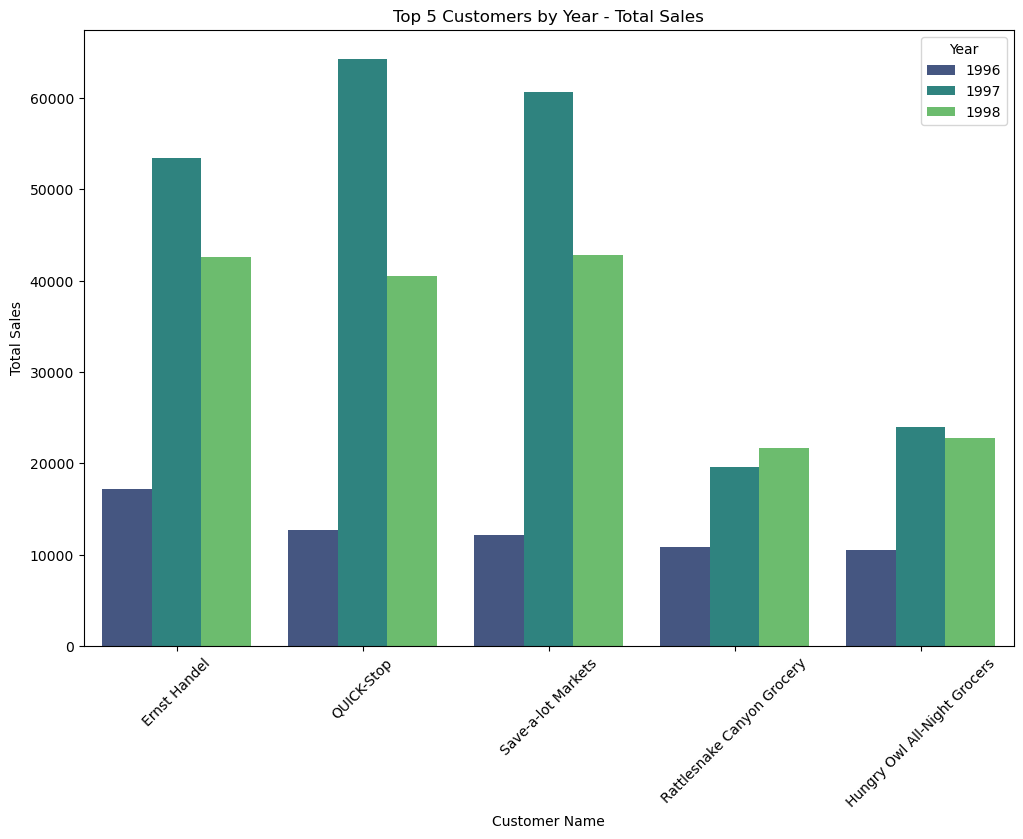

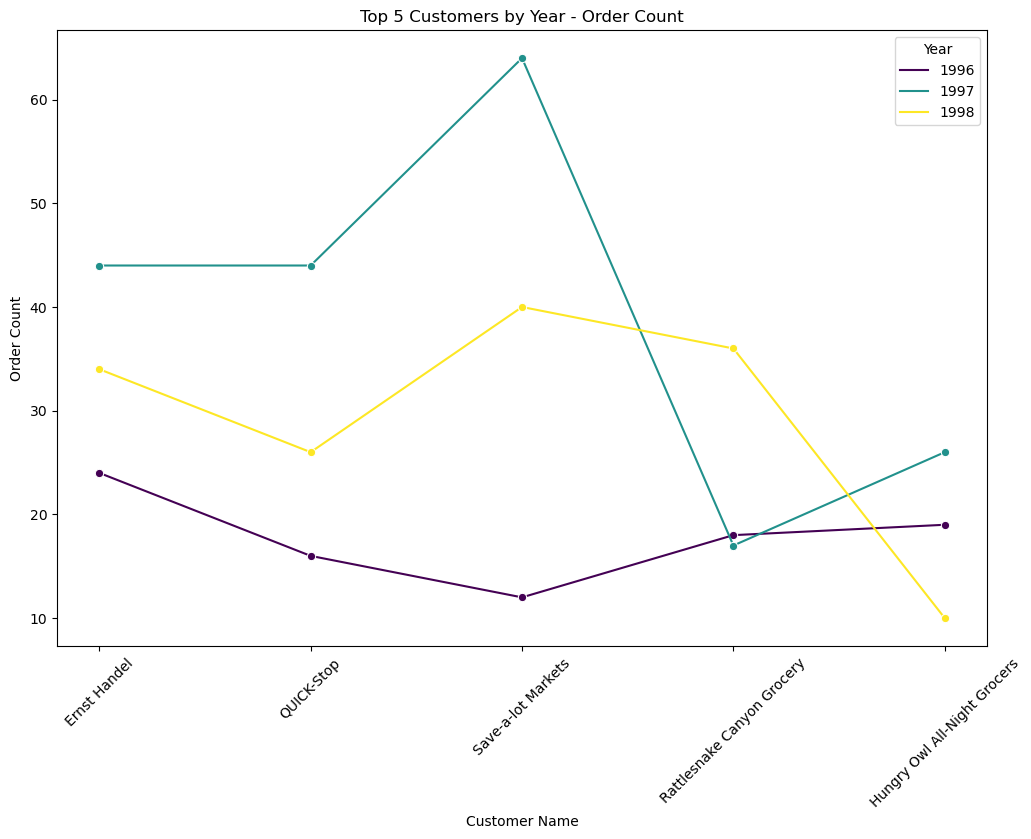

In [48]:
plt.figure(figsize=(12, 8))
sns.barplot(x='customer_name', y='total_sales', hue='year', data=df, palette="viridis")
plt.title('Top 5 Customers by Year - Total Sales')
plt.xlabel('Customer Name')
plt.ylabel('Total Sales')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(12, 8))
sns.lineplot(x='customer_name', y='order_count', hue='year', data=df, marker="o", palette="viridis")
plt.title('Top 5 Customers by Year - Order Count')
plt.xlabel('Customer Name')
plt.ylabel('Order Count')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.show()

# Top Products by Top 5 Customers

In [49]:
query6= """WITH Top5Customers AS (
    SELECT
        c.customer_id,
        c.company_name,
        SUM(od.unit_price * od.quantity) AS Total_Sales
    FROM
        customers c
    JOIN
        orders o ON c.customer_id = o.customer_id
    JOIN
        order_details od ON o.order_id = od.order_id
    GROUP BY
        c.customer_id, c.company_name
    ORDER BY
        Total_Sales DESC
    LIMIT 5
),
CustomerProductPreferences AS (
    SELECT
        c.customer_id,
        c.company_name,
        p.product_id,
        p.product_name,
        cat.category_name,
        SUM(od.quantity) AS Total_Quantity,
        ROW_NUMBER() OVER (PARTITION BY c.customer_id ORDER BY SUM(od.quantity) DESC) AS rn
    FROM
        Top5Customers c
    JOIN
        orders o ON c.customer_id = o.customer_id
    JOIN
        order_details od ON o.order_id = od.order_id
    JOIN
        products p ON od.product_id = p.product_id
    JOIN
        categories cat ON p.category_id = cat.category_id
    GROUP BY
        c.customer_id, c.company_name, p.product_id, p.product_name, cat.category_name
)
SELECT
    customer_id,
    company_name,
    product_name,
    category_name,
    Total_Quantity
FROM
    CustomerProductPreferences
WHERE
    rn = 1
ORDER BY
    Total_Quantity DESC;"""

In [50]:
df = pd.read_sql_query(query6, engine)

In [51]:
print(df.columns)
print(df.dtypes)

Index(['customer_id', 'company_name', 'product_name', 'category_name',
       'total_quantity'],
      dtype='object')
customer_id       object
company_name      object
product_name      object
category_name     object
total_quantity     int64
dtype: object


In [52]:
df['product_category'] = df['product_name'] + ' (' + df['category_name'] + ')'

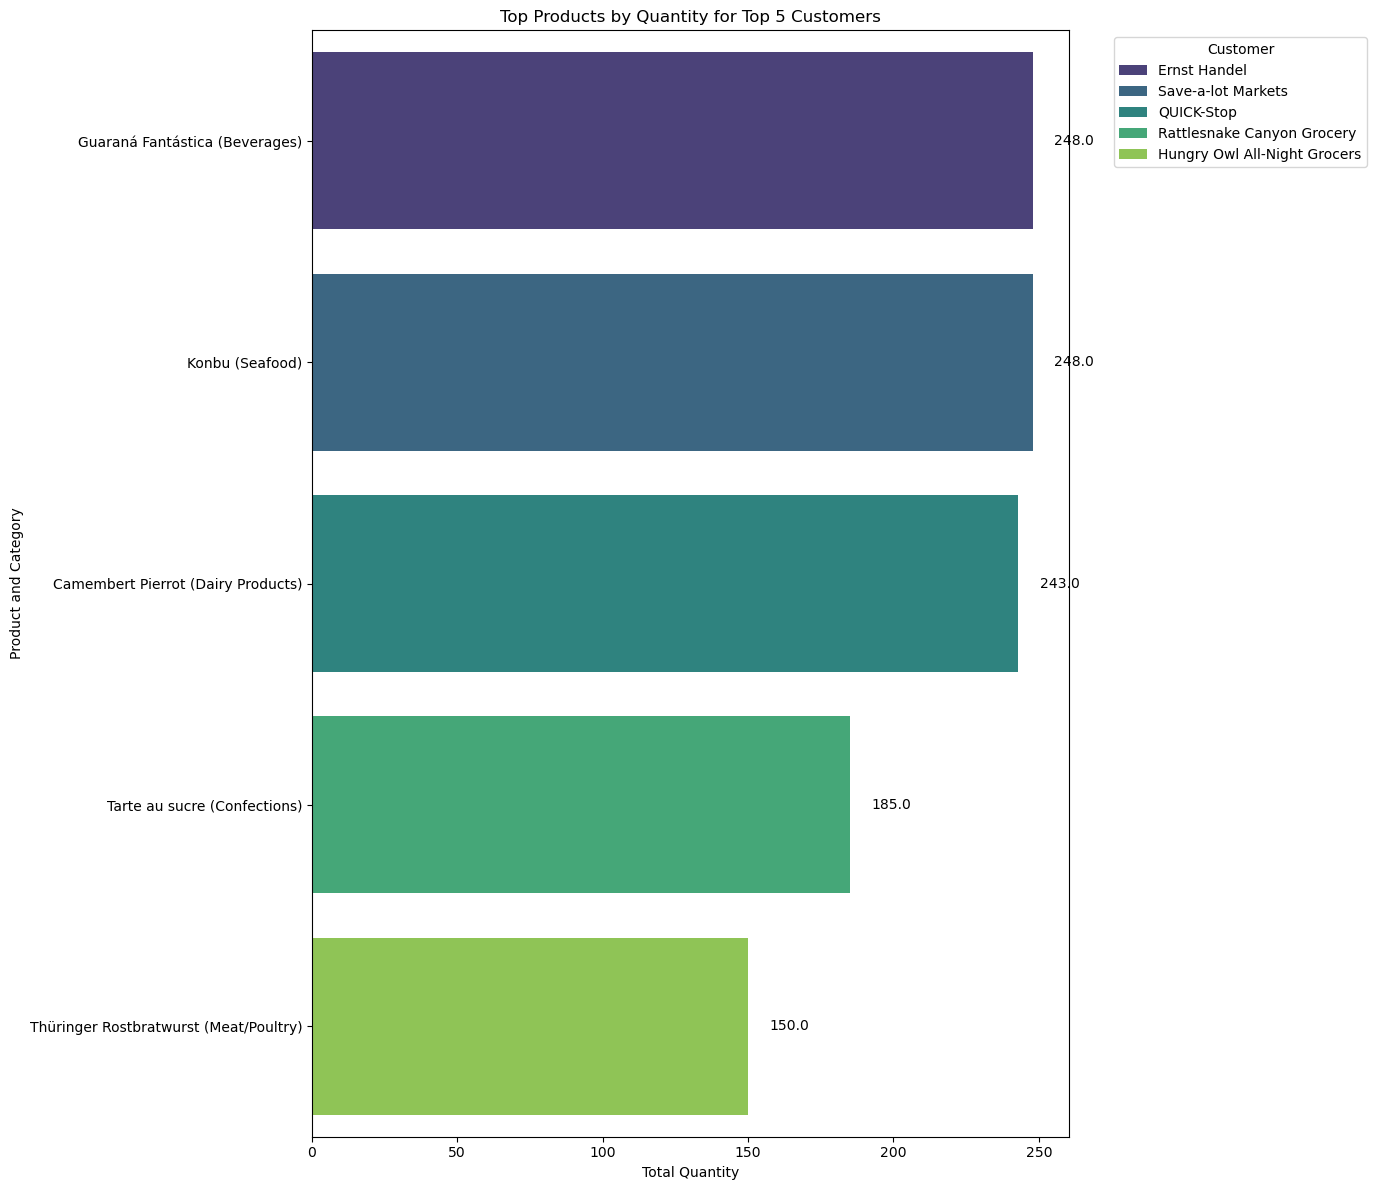

In [53]:
plt.figure(figsize=(14, 12))


ax = sns.barplot(
    data=df,
    x='total_quantity',
    y='product_category',
    hue='company_name',
    palette='viridis',
    dodge=False,
    errorbar=None
)

for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width}', (width + 5, p.get_y() + p.get_height() / 2),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', color='black', fontsize=10)


plt.xticks(rotation=0, ha='center')


plt.title('Top Products by Quantity for Top 5 Customers')
plt.xlabel('Total Quantity')
plt.ylabel('Product and Category')


plt.legend(title='Customer', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.subplots_adjust(right=0.85)


plt.tight_layout()
plt.show()

# The Fastest and Slowest Delivery Time to Customers

In [54]:
query7 = """WITH DeliveryTimes AS (
    SELECT
        c.customer_id AS Customer_ID,
        c.company_name AS Customer_Name,
        c.country AS Country,
        AVG(o.shipped_date - o.order_date) AS Average_Delivery_Time
    FROM
        orders o
    JOIN
        customers c ON o.customer_id = c.customer_id
    WHERE
        o.shipped_date IS NOT NULL
    GROUP BY
        1, 2, 3
)

(SELECT 
    Customer_ID,
    Customer_Name,
     Country,
    Average_Delivery_Time
FROM 
    DeliveryTimes
ORDER BY 
    Average_Delivery_Time ASC
LIMIT 5)
UNION ALL


(SELECT 
    Customer_ID,
    Customer_Name,
     Country,
    Average_Delivery_Time
FROM 
    DeliveryTimes
ORDER BY 
    Average_Delivery_Time DESC
LIMIT 5);"""

In [55]:
df = pd.read_sql_query(query7, engine)

In [56]:
print(df.columns)
print(df.dtypes)

Index(['customer_id', 'customer_name', 'country', 'average_delivery_time'], dtype='object')
customer_id               object
customer_name             object
country                   object
average_delivery_time    float64
dtype: object


In [57]:
df_fastest = df.head(5) 
df_slowest = df.tail(5)  

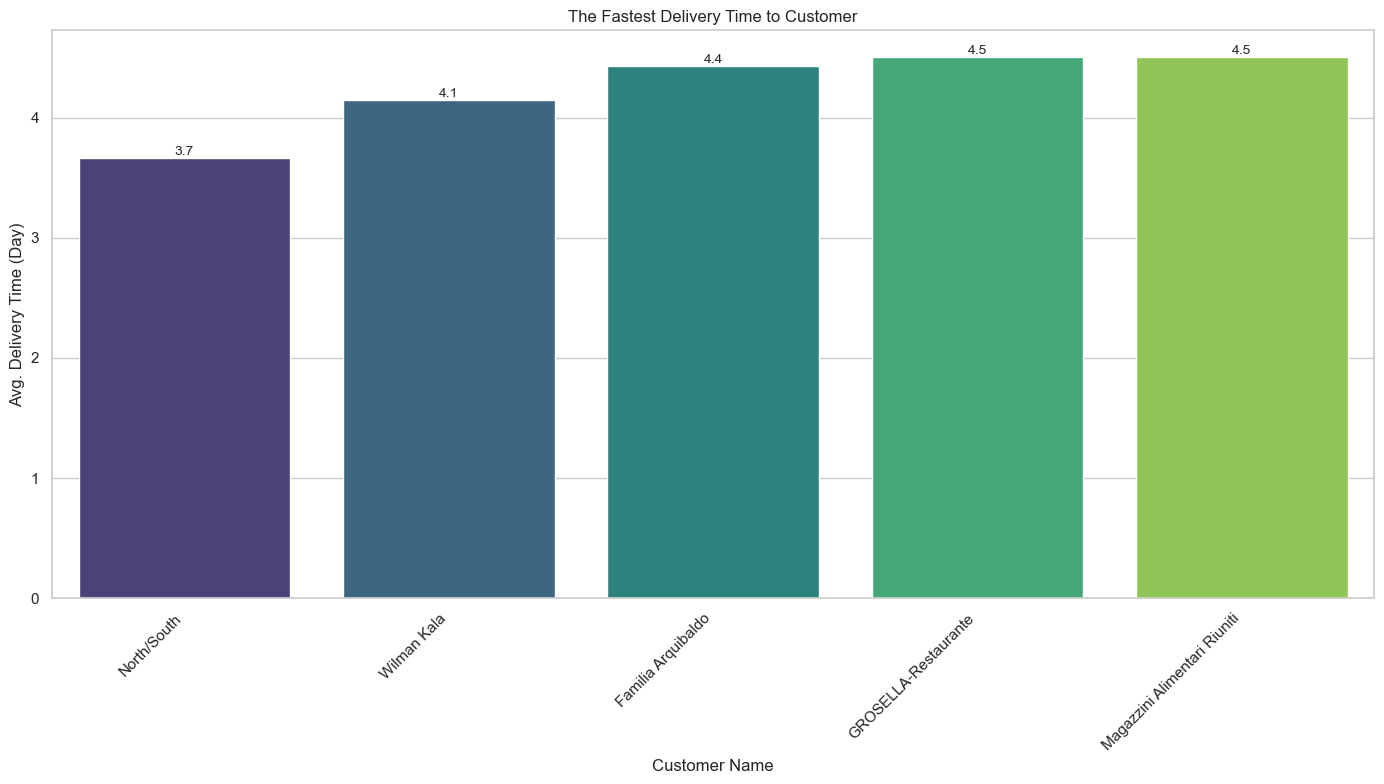

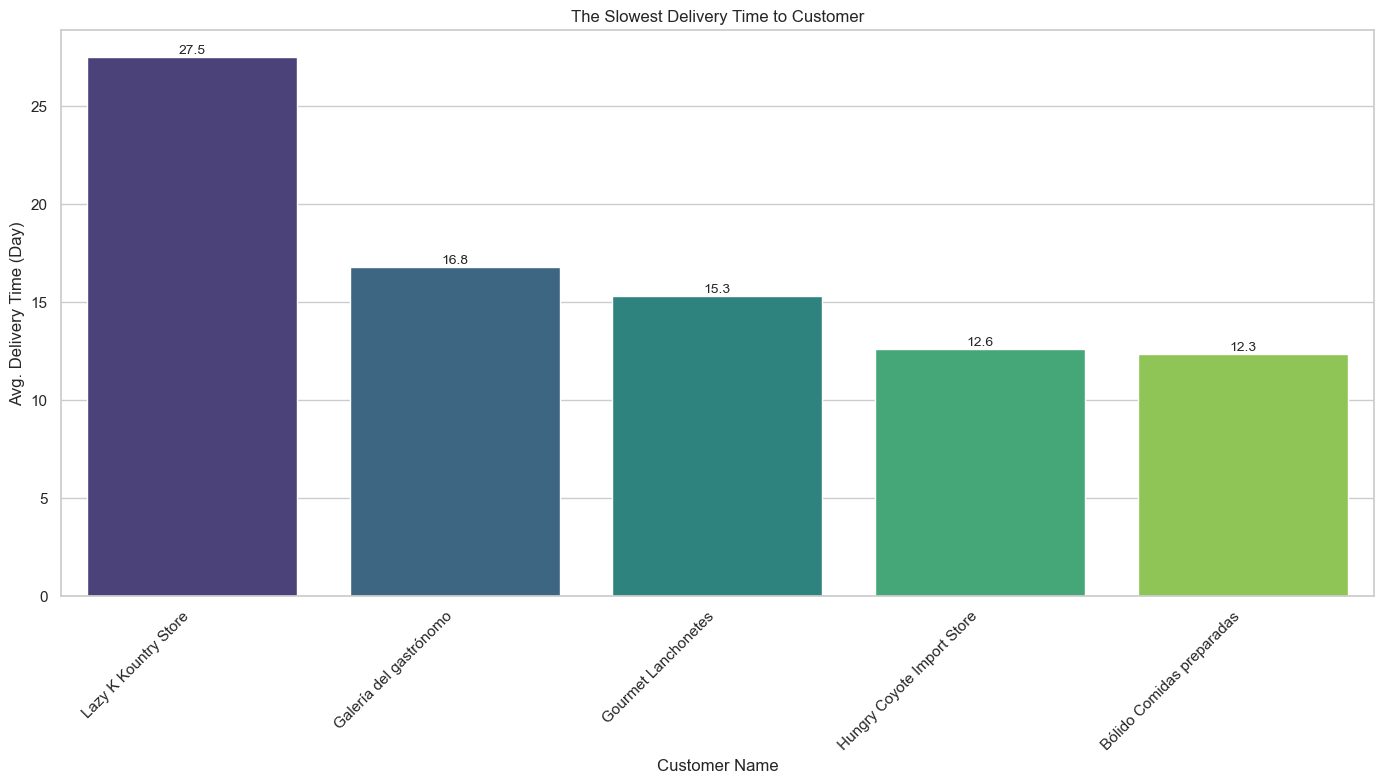

In [58]:
sns.set(style="whitegrid")


df_fastest = df.head(5) 
df_slowest = df.tail(5) 


plt.figure(figsize=(14, 8))
ax1 = sns.barplot(
    data=df_fastest,
    x='customer_name',
    y='average_delivery_time',
    palette='viridis'
)
ax1.set_title('The Fastest Delivery Time to Customer')
ax1.set_xlabel('Customer Name')
ax1.set_ylabel('Avg. Delivery Time (Day)')


for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                  ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
ax2 = sns.barplot(
    data=df_slowest,
    x='customer_name',
    y='average_delivery_time',
    palette='viridis'
)
ax2.set_title('The Slowest Delivery Time to Customer')
ax2.set_xlabel('Customer Name')
ax2.set_ylabel('Avg. Delivery Time (Day)')


for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                  ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()